# Human Speech Classification

In [1]:
# Install Packages
!pip install kaggle --upgrade --quiet
!pip install opendatasets --upgrade --quiet
!pip install librosa --upgrade --quiet
!pip install noisereduce --upgrade --quiet

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import opendatasets as od
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
import librosa
import librosa.display
import wave

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import prjLib as lib

import warnings
warnings.filterwarnings ('ignore')

In [3]:
# Parameters

FRAME_LEN = 4096
HOP_LEN = 2048
N = 14

## Preprocessing and Feature Extraction

In [4]:
# Download Dataset
ravdess = ['RAVDESS','https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio','ravdess-emotional-speech-audio/audio_speech_actors_01-24']
tess = ['TESS','https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess','toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data']
cremad = ['CREMA-D','https://www.kaggle.com/datasets/ejlok1/cremad','cremad/AudioWAV']
savee = ['SAVEE','https://www.kaggle.com/datasets/barelydedicated/savee-database','savee-database/AudioData/AudioData']
data_paths = [ravdess,tess,cremad,savee] # ravdess,tess,cremad,savee

for data_path in tqdm(data_paths,desc="Downloading Datasets"):
    if (os.path.exists(data_path[2]) == False):
        od.download(data_path[1])

In [5]:
# Functions

def FixSamples(sample,sr,max_seconds):
    leng = sr * 2 * max_seconds
    fix_sample = np.zeros([leng,1])
    fix_sample[leng-len(sample):] = sample.reshape(sample.shape[0],1)
    return fix_sample[:,0]

def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    gender = 0
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
        gender = int(audio_file_path[18:20]) & 0x1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
        if 'OAF_' in audio_file_path:
            gender = 1
        if 'YAF_' in audio_file_path:
            gender = 0
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
        speaker_id = int(audio_file_path[0:4])
        df = pd.read_csv('cremad/VideoDemographics.csv')
        df = df.loc[df['ActorID'] == speaker_id]
        gender = int(df['Sex'] == 'Male')
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
        gender = 1
    return np.concatenate(np.array([emotion,gender]).reshape(1,2),axis=0)

'''
def MyZCR(sample,z):
    sample -= z
    zcr = 0
    for ii in range(len(sample)-1):
        if sample[ii]*sample[ii+1] < 0:
            zcr += 1
    return zcr
'''

def extract_mvs(feature,leng,axis):
    Mean = np.mean(feature,axis=axis).reshape(leng,1)
    Var = np.var(feature,axis=axis).reshape(leng,1)
    Sum = np.sum(feature,axis=axis).reshape(leng,1)
    Max = np.max(feature,axis=axis).reshape(leng,1)
    ArgMax = np.argmax(feature,axis=axis).reshape(leng,1)
    MaxMeanRatio = Max / Mean
    ArgMaxArgsRatio = ArgMax / feature.shape[1]
    return [Mean, Var, Sum, MaxMeanRatio, ArgMaxArgsRatio]

def extract_tempogram(sample):
    tempogram = librosa.feature.tempogram(y=sample)
    tempogramMvsT = extract_mvs(tempogram,leng=tempogram.shape[0],axis=1)
    tempogramMvsF = extract_mvs(tempogram,leng=tempogram.shape[1],axis=0)
    tempogram_f = [ tempogram, 
                    tempogramMvsT[0], tempogramMvsT[1], tempogramMvsT[2], tempogramMvsT[3], tempogramMvsT[4],
                    tempogramMvsF[0], tempogramMvsF[1], tempogramMvsF[2], tempogramMvsF[3], tempogramMvsF[4] ]
    return tempogram_f

def extract_fourier_tempogram(sample):
    ftempogram = librosa.feature.fourier_tempogram(y=sample)
    ftempogramMvsT = extract_mvs(ftempogram,leng=ftempogram.shape[0],axis=1)
    ftempogramMvsF = extract_mvs(ftempogram,leng=ftempogram.shape[1],axis=0)
    ftempogram_f = [    ftempogram, 
                        ftempogramMvsT[0], ftempogramMvsT[1], ftempogramMvsT[2], ftempogramMvsT[3], ftempogramMvsT[4],
                        ftempogramMvsF[0], ftempogramMvsF[1], ftempogramMvsF[2], ftempogramMvsF[3], ftempogramMvsF[4] ]
    return ftempogram_f

def extract_tempogram_ratio(sample):
    rtempogram = librosa.feature.tempogram_ratio(y=sample)
    rtempogramMvsT = extract_mvs(rtempogram,leng=rtempogram.shape[0],axis=1)
    rtempogramMvsF = extract_mvs(rtempogram,leng=rtempogram.shape[1],axis=0)
    rtempogram_f = [    rtempogram, 
                        rtempogramMvsT[0], rtempogramMvsT[1], rtempogramMvsT[2], rtempogramMvsT[3], rtempogramMvsT[4],
                        rtempogramMvsF[0], rtempogramMvsF[1], rtempogramMvsF[2], rtempogramMvsF[3], rtempogramMvsF[4] ]
    return rtempogram_f

def extract_zcr(sample):
    zcr = librosa.feature.zero_crossing_rate(y=sample)
    mvs = extract_mvs(zcr,leng=1,axis=1)
    return [zcr, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_rms(sample,z):
    rms = librosa.feature.rms(y=sample)
    mvs = extract_mvs(rms,leng=1,axis=1)
    # scr = MyZCR(rms,z)
    return [rms, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]] # , scr

def extract_mfcc(sample,sr,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc)
    mfccMvsT = extract_mvs(mfcc,leng=mfcc.shape[0],axis=1)
    mfccMvsF = extract_mvs(mfcc,leng=mfcc.shape[1],axis=0)
    mfcc_f = [  mfcc, 
                mfccMvsT[0], mfccMvsT[1], mfccMvsT[2], mfccMvsT[3], mfccMvsT[4],
                mfccMvsF[0], mfccMvsF[1], mfccMvsF[2], mfccMvsF[3], mfccMvsF[4] ]
    return mfcc_f

'''
def extract_dmfcc(mfcc):
    dmfcc = librosa.feature.delta(mfcc)
    dmfccMvsT = extract_mvs(dmfcc,leng=dmfcc.shape[0],axis=1)
    dmfccMvsF = extract_mvs(dmfcc,leng=dmfcc.shape[1],axis=0)
    dmfcc_f = [ dmfcc, 
                dmfccMvsT[0], dmfccMvsT[1], dmfccMvsT[2], dmfccMvsT[3], dmfccMvsT[4],
                dmfccMvsF[0], dmfccMvsF[1], dmfccMvsF[2], dmfccMvsF[3], dmfccMvsF[4]    ]
    return dmfcc_f

def extract_ber(mfcc,F):
    ber = np.zeros([1,mfcc.shape[1]])
    for tt in range(mfcc.shape[1]):
        ber[:,tt] = (mfcc[0:F,tt].T @ mfcc[0:F,tt]) / (mfcc[F:,tt].T @ mfcc[F:,tt]) # np.sum(np.square(mfcc[0:F,tt])) / np.sum(np.square(mfcc[F:,tt]))
    berMvsT = extract_mvs(ber,leng=ber.shape[0],axis=1)
    berMvsF = extract_mvs(ber,leng=ber.shape[1],axis=0)
    ber_f = [   ber, 
                berMvsT[0], berMvsT[1], berMvsT[2], berMvsT[3], berMvsT[4],
                berMvsF[0], berMvsF[1], berMvsF[2], berMvsF[3], berMvsF[4]    ]
    return ber_f

def extract_scentoid(mfcc):
    sc = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        sc[:,tt] = (mfcc[:,tt].T @ n) / (mfcc[:,tt].T @ I)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    scMvsF = extract_mvs(sc,leng=sc.shape[1],axis=0)
    sc_f = [    sc, 
                scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4],
                scMvsF[0], scMvsF[1], scMvsF[2], scMvsF[3], scMvsF[4]    ]
    return sc_f

def extract_sbandwidth(mfcc,sc):
    bw = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        var = np.abs(n-sc[tt])
        bw[:,tt] = (mfcc[:,tt].T @ var) / (mfcc[:,tt].T @ I)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    bwMvsF = extract_mvs(bw,leng=bw.shape[1],axis=0)
    bw_f = [    bw, 
                bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4],
                bwMvsF[0], bwMvsF[1], bwMvsF[2], bwMvsF[3], bwMvsF[4]    ]
    return bw_f
'''

def extract_scentroid(sample):
    sc = librosa.feature.spectral_centroid(y=sample)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    return [sc, scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4]]

def extract_sbandwidth(sample):
    bw = librosa.feature.spectral_bandwidth(y=sample)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    return [bw, bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4]]

def extract_spectral_contrast(sample):
    scontrast = librosa.feature.spectral_contrast(y=sample)
    scontrastMvsT = extract_mvs(scontrast,leng=scontrast.shape[0],axis=1)
    scontrastMvsF = extract_mvs(scontrast,leng=scontrast.shape[1],axis=0)
    scontrast_f = [ scontrast, 
                    scontrastMvsT[0], scontrastMvsT[1], scontrastMvsT[2], scontrastMvsT[3], scontrastMvsT[4],
                    scontrastMvsF[0], scontrastMvsF[1], scontrastMvsF[2], scontrastMvsF[3], scontrastMvsF[4] ]
    return scontrast_f

def extract_spectral_flatness(sample):
    sflat = librosa.feature.spectral_flatness(y=sample)
    mvs = extract_mvs(sflat,leng=1,axis=1)
    return [sflat, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_spectral_rolloff(sample):
    sroll = librosa.feature.spectral_rolloff(y=sample)
    mvs = extract_mvs(sroll,leng=1,axis=1)
    return [sroll, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_poly_features(sample):
    poly = librosa.feature.poly_features(y=sample)
    polyMvsT = extract_mvs(poly,leng=poly.shape[0],axis=1)
    polyMvsF = extract_mvs(poly,leng=poly.shape[1],axis=0)
    poly_f = [  poly, 
                polyMvsT[0], polyMvsT[1], polyMvsT[2], polyMvsT[3], polyMvsT[4],
                polyMvsF[0], polyMvsF[1], polyMvsF[2], polyMvsF[3], polyMvsF[4] ]
    return poly_f

def extract_tonnetz(sample):
    tonnetz = librosa.feature.tonnetz(y=sample)
    tonnetzMvsT = extract_mvs(tonnetz,leng=tonnetz.shape[0],axis=1)
    tonnetzMvsF = extract_mvs(tonnetz,leng=tonnetz.shape[1],axis=0)
    tonnetz_f = [   tonnetz, 
                    tonnetzMvsT[0], tonnetzMvsT[1], tonnetzMvsT[2], tonnetzMvsT[3], tonnetzMvsT[4],
                    tonnetzMvsF[0], tonnetzMvsF[1], tonnetzMvsF[2], tonnetzMvsF[3], tonnetzMvsF[4] ]
    return tonnetz_f

def ExtractFeatures(sample,sr,frame_len,hop_len,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc, n_fft=frame_len, win_length=frame_len, hop_length=hop_len)
    mfcc_mean = np.mean(mfcc,axis=1).reshape(mfcc.shape[0],1)
    '''
    # tempo_f = librosa.feature.tempo(y=sample).reshape(1,1)
    # # tempogram_f = extract_tempogram(sample)
    # # ftempogram_f = extract_fourier_tempogram(sample)
    # rtempogram_f = extract_tempogram_ratio(sample)
    # zcr_f = extract_zcr(sample)
    # rms_f = extract_rms(sample,z_threshold)
    # mfcc_f = extract_mfcc(sample,sr,n_mfcc)
    # # X dmfcc_f = extract_dmfcc(mfcc_f[0])
    # # X ddmfcc_f = extract_dmfcc(dmfcc_f[0])
    # # X ber_f = extract_ber(mfcc_f[0],F)
    # sc_f = extract_scentroid(sample)
    # bw_f = extract_sbandwidth(sample)
    # scont_f = extract_spectral_contrast(sample)
    # sflat_f = extract_spectral_flatness(sample)
    # sroll_f = extract_spectral_rolloff(sample)
    # poly_f = extract_poly_features(sample)
    # tonnetz_f = extract_tonnetz(sample)
    features = np.concatenate(( # tempo_f,
                                # # tempogram_f[0].T,
                                # # tempogram_f[1], tempogram_f[2], tempogram_f[3], tempogram_f[4], tempogram_f[5],
                                # # tempogram_f[6], tempogram_f[7], tempogram_f[8], tempogram_f[9], tempogram_f[10],
                                # # ftempogram_f[0].T,
                                # # ftempogram_f[1], ftempogram_f[2], ftempogram_f[3], ftempogram_f[4], ftempogram_f[5],
                                # # ftempogram_f[6], ftempogram_f[7], ftempogram_f[8], ftempogram_f[9], ftempogram_f[10],
                                # # rtempogram_f[0].T,
                                # rtempogram_f[1], rtempogram_f[2], rtempogram_f[3], rtempogram_f[4], rtempogram_f[5],
                                # # rtempogram_f[6], rtempogram_f[7], rtempogram_f[8], rtempogram_f[9], rtempogram_f[10],
                                # # zcr_f[0].T, # 69%
                                # zcr_f[1], zcr_f[2], zcr_f[3], zcr_f[4], zcr_f[5], # 60%
                                # # rms_f[0].T, # 72%
                                # rms_f[1], rms_f[2], rms_f[3], rms_f[4], rms_f[5], # 64%
                                # # np.array([rms_f[6]]).reshape(1,1), # 18%
                                # # np.array([1,2,3]).reshape(3,1), mfcc_f[0].reshape(mfcc_f[0].shape[0]*mfcc_f[0].shape[1],1) # 72%
                                # mfcc_f[1], mfcc_f[2], mfcc_f[3], mfcc_f[4], mfcc_f[5], # 75%
                                # # mfcc_f[6], mfcc_f[7], mfcc_f[8], mfcc_f[9], mfcc_f[10], # 72%
                                # # dmfcc_f[0].reshape(dmfcc_f[0].shape[0]*dmfcc_f[0].shape[1],1), # 68%
                                # # dmfcc_f[1], dmfcc_f[2], dmfcc_f[3], dmfcc_f[4], dmfcc_f[5], # Nun
                                # # dmfcc_f[6], dmfcc_f[7], dmfcc_f[8], dmfcc_f[9], dmfcc_f[10], # 61%
                                # # ddmfcc_f[0].reshape(ddmfcc_f[0].shape[0]*ddmfcc_f[0].shape[1],1), # 67%
                                # # ddmfcc_f[1], ddmfcc_f[2], ddmfcc_f[3], ddmfcc_f[4], ddmfcc_f[5], # Nun
                                # # ddmfcc_f[6], ddmfcc_f[7], ddmfcc_f[8], ddmfcc_f[9], ddmfcc_f[10], # 58%
                                # # ber_f[0].T, np.array([1,2,3]).reshape(3,1) # Nun
                                # # ber_f[1], ber_f[2], ber_f[3], ber_f[4], ber_f[5], # Nun
                                # # sc_f[0].T, # 67%
                                # sc_f[1], sc_f[2], sc_f[3], sc_f[4], sc_f[5],# 60%
                                # # bw_f[0].T, # 65%
                                # bw_f[1], bw_f[2], bw_f[3], bw_f[4], bw_f[5], # 57%
                                # scont_f[1], scont_f[2], scont_f[3], scont_f[4], scont_f[5],
                                # # scont_f[6], scont_f[7], scont_f[8], scont_f[9], scont_f[10],
                                # sflat_f[1], sflat_f[2], sflat_f[3], sflat_f[4], sflat_f[5],
                                # sroll_f[1], sroll_f[2], sroll_f[3], sroll_f[4], sroll_f[5],
                                # poly_f[1], poly_f[2], poly_f[3], poly_f[4], poly_f[5],
                                # # poly_f[6], poly_f[7], poly_f[8], poly_f[9], poly_f[10],
                                # tonnetz_f[1], tonnetz_f[2], tonnetz_f[3], tonnetz_f[4], tonnetz_f[5],
                                # # tonnetz_f[6], tonnetz_f[7], tonnetz_f[8], tonnetz_f[9], tonnetz_f[10],
                                ),axis=0)[:,0]
    '''
    # features = np.concatenate(( mfcc_mean[:,0], mfcc_median[:,0] ),axis=0)[:,0]
    return mfcc_mean[:,0] # features

def TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators,min_samples_split,random_state, plot=True):
    if plot:
        lib.PlotCorrMap(train_data, train_labels)
        #lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])
    report, score, model = lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, paramC=1,kernelType='rbf',n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state, plot=plot)
    feature_importance = []
    if plot:
        feature_importance = lib.FeaturesImportance(model,train_data)
    return report, score, feature_importance


In [ ]:
def extract_mvs_tf(feat_mat):
    fmMvsT = extract_mvs(feat_mat,leng=feat_mat.shape[0],axis=1)
    fmMvsF = extract_mvs(feat_mat,leng=feat_mat.shape[1],axis=0)
    fm_f = [    fmMvsT[0], fmMvsT[1], fmMvsT[2], fmMvsT[3], fmMvsT[4],
                fmMvsF[0], fmMvsF[1], fmMvsF[2], fmMvsF[3], fmMvsF[4] ]
    return fm_f

sample, sr = librosa.load('ravdess-emotional-speech-audio/Actor_01/03-01-06-02-01-01-01.wav')
display(sample.shape)

feat = librosa.feature.tempo(y=sample)
display(feat.shape)

feat = librosa.feature.tempogram(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

feat = librosa.feature.fourier_tempogram(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

feat = librosa.feature.tempogram_ratio(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

feat = librosa.feature.spectral_contrast(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

feat = librosa.feature.spectral_flatness(y=sample)
mvs_t = extract_mvs(feat,leng=feat.shape[0],axis=1)
display(feat.shape)

feat = librosa.feature.spectral_rolloff(y=sample)
mvs_t = extract_mvs(feat,leng=feat.shape[0],axis=1)
display(feat.shape)

feat = librosa.feature.poly_features(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

feat = librosa.feature.tonnetz(y=sample)
mvs_tf = extract_mvs_tf(feat)
display(feat.shape)

In [6]:
# Collect Data and Extract Features from audio files
dump_filename_data = 'featured_data.csv'
dump_filename_label = 'labels.csv'
if False: # os.path.isfile(dump_filename_data) and os.path.isfile(dump_filename_label):
    featured_data = lib.LoadCsv(dump_filename_data)
    labels = lib.LoadCsv(dump_filename_label)
else:
    featured_data = []  # stores the features
    labels = []  # stores the labels
    for data_path in tqdm(data_paths,desc="Collecting Datasets"):
        root_dir = data_path[2]
        cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
        for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
            for file in files:
                if not '.wav' in file:
                    continue
                audio_file_path = os.path.join(subdirs, file)
                sample, sr = librosa.load(audio_file_path)
                # sample_nr = nr.reduce_noise(y=sample, sr=sr)
                #if not np.isfinite(sample_nr).all():
                #    continue
                fix_sample = FixSamples(sample,sr,4)
                features = ExtractFeatures(fix_sample,sr,FRAME_LEN,HOP_LEN,N)
                label = ExtractLabel(file,data_path[0])
                featured_data.append(features)
                labels.append(label)
    featured_data = np.asarray(featured_data)
    labels = np.array(labels)
    #lib.SaveCsv(dump_filename_data,featured_data)
    #lib.SaveCsv(dump_filename_label,labels)
print(f'Data with total {featured_data.shape[0]} samples collected with {featured_data.shape[1]} features.')

Processing RAVDESS audio files:   0%|          | 0/25 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/15 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/1 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/5 [00:00<?, ?file/s]

Data with total 12162 samples collected with 14 features.


In [135]:
lib.SaveCsv(dump_filename_data,featured_data)
lib.SaveCsv(dump_filename_label,labels)

In [375]:
# Split data to Male/Female
display(featured_data.shape)
display(labels.shape)
featured_data_sex = np.concatenate(( featured_data, labels[:,1].reshape(labels.shape[0],1) ),axis=1)
labels_sex = labels[:,0]
display(featured_data_sex.shape)
display(labels_sex.shape)

(8401, 14)

(8401, 2)

(8401, 15)

(8401,)

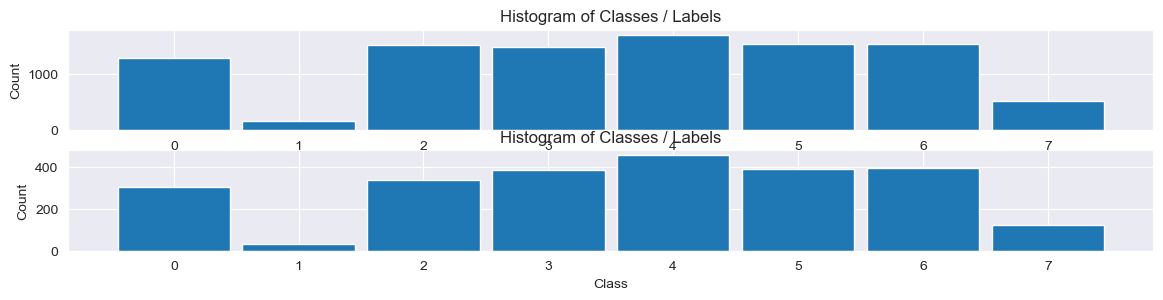

In [7]:
# Data samples split
train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data,labels[:,0],trainRatio=0.8)

In [242]:
# Select features
delete_features_indexes = np.concatenate((np.arange(0,76),np.arange(146,241)),axis=0)
train_data = np.delete(train_data,delete_features_indexes,axis=1)
test_data = np.delete(test_data,delete_features_indexes,axis=1)
print(f'Selected {train_data.shape[1]} features.')

Selected 70 features.


In [8]:
# Data extrapulation of train data, for uniform histogram of classes
dataL1 = train_data[(train_labels==1)]
L1 = train_labels[(train_labels==1)]
dataL7 = train_data[(train_labels==7)]
L7 = train_labels[(train_labels==7)]
train_data = np.concatenate((train_data,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
train_labels = np.concatenate((train_labels,L1,L1,L1,L1,L1,L7),axis=0)
print(f'Train Data extrapulated with total {train_data.shape[0]} samples collected with {train_data.shape[1]} features.')

# Data extrapulation of test data, for uniform histogram of classes
dataL1 = test_data[(test_labels==1)]
L1 = test_labels[(test_labels==1)]
dataL7 = test_data[(test_labels==7)]
L7 = test_labels[(test_labels==7)]
test_data = np.concatenate((test_data,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
test_labels = np.concatenate((test_labels,L1,L1,L1,L1,L1,L7),axis=0)
print(f'Test Data extrapulated with total {test_data.shape[0]} samples collected with {test_data.shape[1]} features.')

Train Data extrapulated with total 11051 samples collected with 14 features.
Test Data extrapulated with total 2723 samples collected with 14 features.


In [9]:
# Delete NaN values
nan_raw = np.argwhere(np.isnan(train_data))[0,0]
train_data = np.delete(train_data,nan_raw,0)
train_labels = np.delete(train_labels,nan_raw,0)
display(train_data.shape)

IndexError: index 0 is out of bounds for axis 0 with size 0

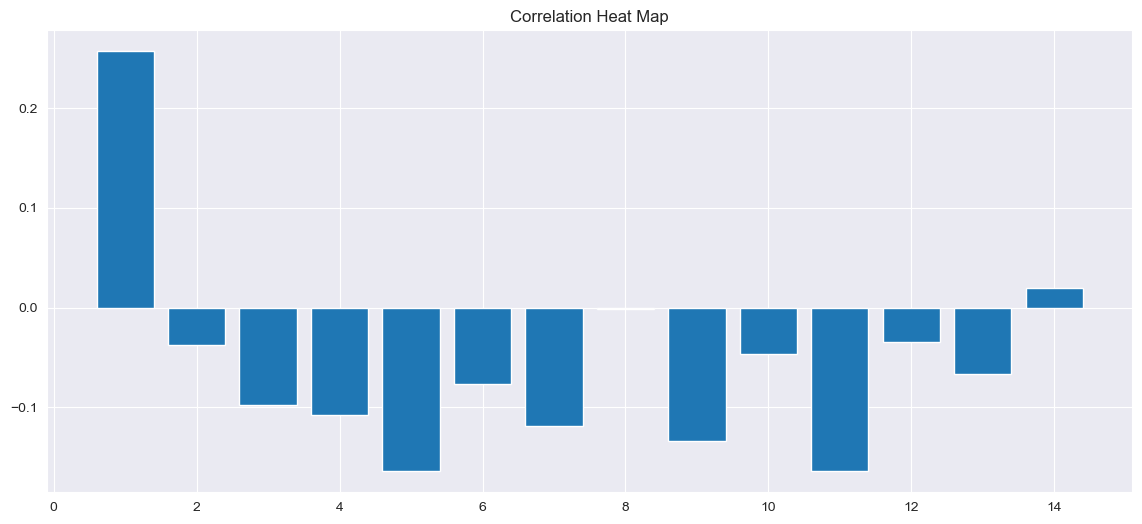

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [10]:
# Test features with a simple model
n_estimators = 100
min_samples_split = 6
random_state = 1

score, feature_importance = TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state)

In [ ]:
from sklearn.linear_model import lars_path, lasso_path

dfX = lib.Numpy2Pandas(train_data)
dsY = lib.Numpy2Pandas(train_labels.reshape(train_labels.shape[0],1))

# LASSO Path Analysis
alphasPath, coefsPath, *_ = lasso_path(dfX, dsY)
alphasPath = alphasPath.reshape(alphasPath.shape[0],1)
coefsPath = coefsPath[0,:,:]
display(alphasPath.shape)
display(coefsPath.shape)

# Display the LASSO Path
'''
hF, hA = plt.subplots(figsize = (16, 8))
hA.plot(alphasPath, np.abs(coefsPath.T), lw = 2, label = dfX.columns.to_list())
hA.set_title('The Lasso Path')
hA.set_xlabel('$\lambda$')
hA.set_ylabel('Coefficient Value (${w}_{i}$)')
hA.legend()
plt.show()
'''

_, _, coefs = lars_path(dfX, dsY, method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

In [199]:
# Remove weak features
weak_features_indexes = np.where(feature_importance < 0.02)[0]
train_data = np.delete(train_data,weak_features_indexes,axis=1)
test_data = np.delete(test_data,weak_features_indexes,axis=1)
display(train_data.shape[1])

1

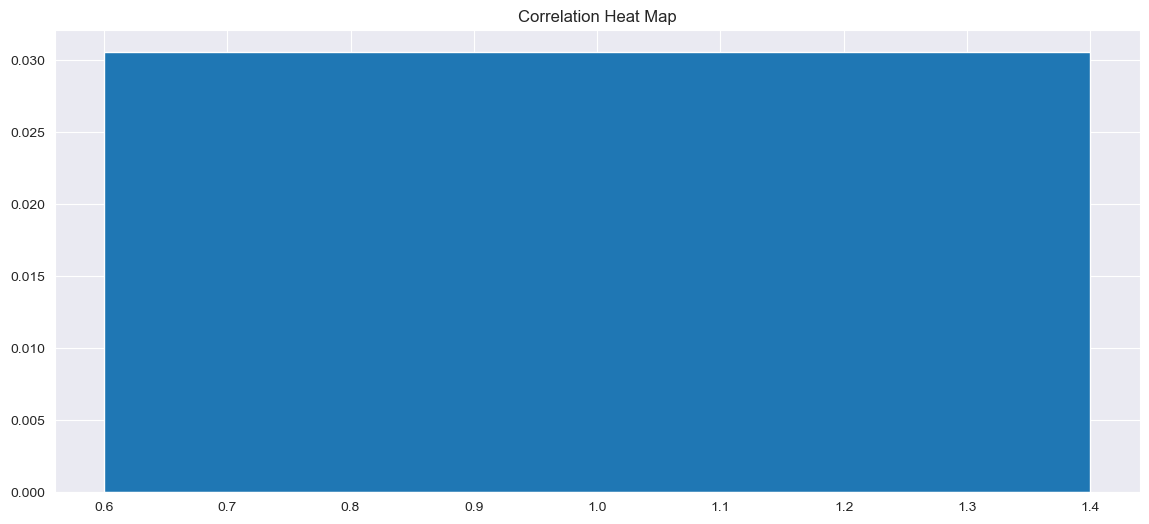

Prediction Train Accuracy: 82.71 %
Prediction Test Accuracy: 45.16 %


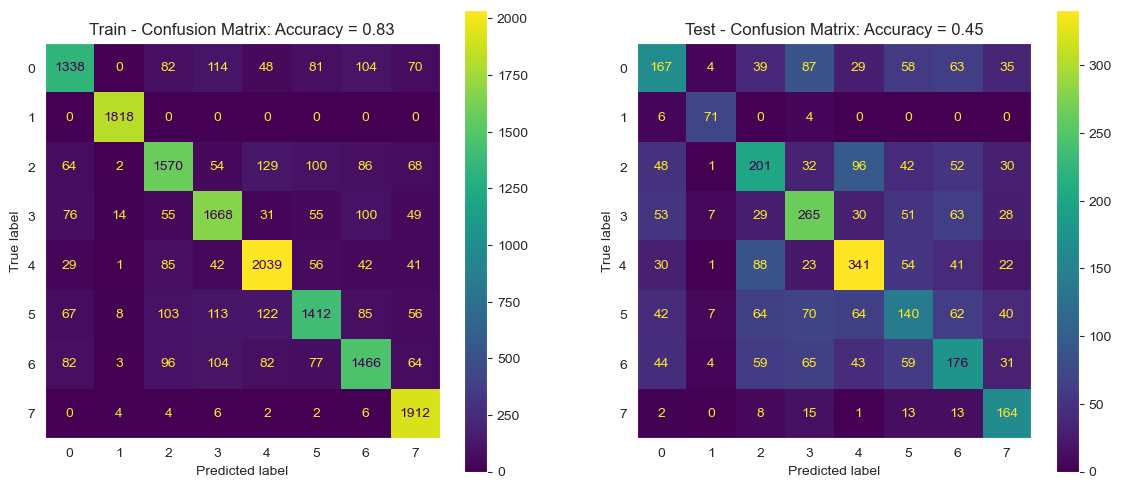

(0.45158424637252, array([1.]))

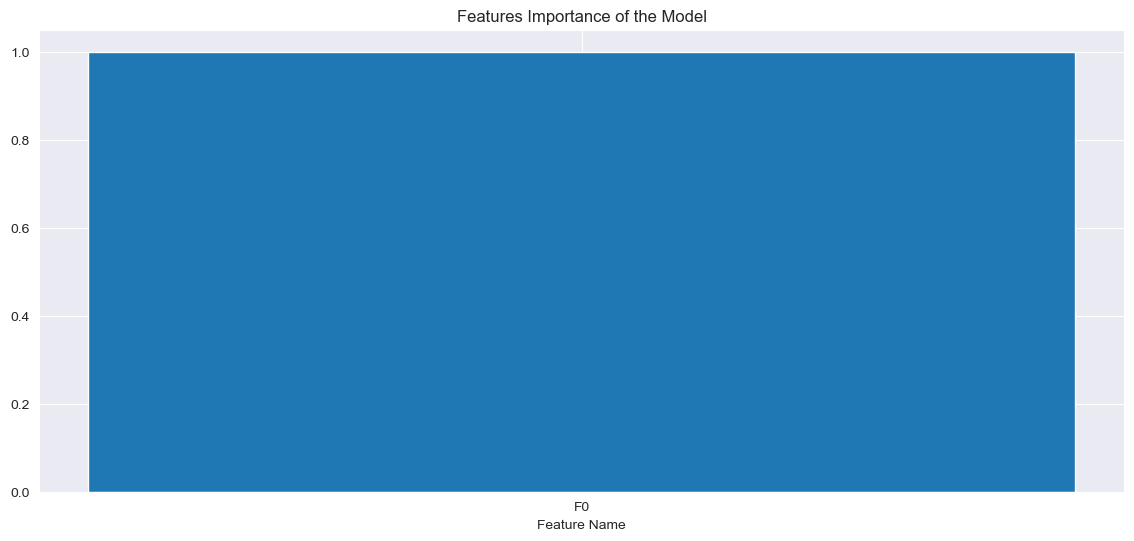

In [200]:
# Test  again after removing not important features
TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state)

## Search for best Classifier (with different hyperparameters)

In [263]:
def FeaturesGridSearch(frame_len,hop_len,N, plot):
    # Collect Data and Extract Features from audio files
    featured_data = []  # stores the features
    labels = []  # stores the labels
    for data_path in tqdm(data_paths,desc="Collecting Datasets"):
        root_dir = data_path[2]
        cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
        for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
            for file in files:
                if not '.wav' in file:
                    continue
                audio_file_path = os.path.join(subdirs, file)
                sample, sr = librosa.load(audio_file_path)
                # fix_sample = FixSamples(sample,sr,4)
                features = ExtractFeatures(sample,sr,frame_len,hop_len,N)
                label = ExtractLabel(file,data_path[0])
                featured_data.append(features)
                labels.append(label)
    featured_data = np.asarray(featured_data)
    labels = np.array(labels)
    print(f'Data with total {featured_data.shape[0]} samples collected with {featured_data.shape[1]} features.')

    # Data samples split
    train_data,train_labels,test_data,test_labels = lib.PlotSplitData(featured_data,labels,trainRatio=0.8,plot=plot)

    '''
    # Select features
    delete_features_indexes = np.arange(0,0)
    train_data = np.delete(train_data,delete_features_indexes,axis=1)
    test_data = np.delete(test_data,delete_features_indexes,axis=1)
    print(f'Selected {train_data.shape[1]} features.')
    '''

    # Data extrapulation of train data, for uniform histogram of classes
    dataL1 = train_data[(train_labels==1)]
    L1 = train_labels[(train_labels==1)]
    dataL7 = train_data[(train_labels==7)]
    L7 = train_labels[(train_labels==7)]
    train_data = np.concatenate((train_data,dataL1,dataL1,dataL1,dataL1,dataL1,dataL7),axis=0)
    train_labels = np.concatenate((train_labels,L1,L1,L1,L1,L1,L7),axis=0)
    print(f'Train Data extrapulated with total {train_data.shape[0]} samples collected with {train_data.shape[1]} features.')

    # Test features with a simple model
    n_estimators = 100
    min_samples_split = 6
    random_state = 512
    score, feature_importance = TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state, plot=plot)
    return score


In [ ]:
# Collect Data and Extract Features from audio files
dump_filename_data = 'sampled_data.csv'
dump_filename_label = 'labels.csv'
sampled_data = np.zeros([16882,44100*4],dtype=np.float32)
labels = np.zeros([16882,1],dtype=np.float32)
ii = 0
if os.path.isfile(dump_filename_data) and os.path.isfile(dump_filename_label):
    sampled_data = lib.LoadCsv(dump_filename_data)
    labels = lib.LoadCsv(dump_filename_label)
else:
    for data_path in tqdm(data_paths,desc="Collecting Datasets"):
        root_dir = data_path[2]
        cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
        for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
            for file in files:
                if not '.wav' in file:
                    continue
                audio_file_path = os.path.join(subdirs, file)
                sample, sr = librosa.load(audio_file_path)
                sampled_data[ii,:] = FixSamples(sample,sr,4)
                labels[ii,0] = ExtractLabel(file,data_path[0])
                ii += 1
    lib.SaveCsv(dump_filename_data,sampled_data)
    lib.SaveCsv(dump_filename_label,labels)
print(f'Data with total {sampled_data.shape[0]} samples collected with {sampled_data.shape[1]} features.')

Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 40 features.


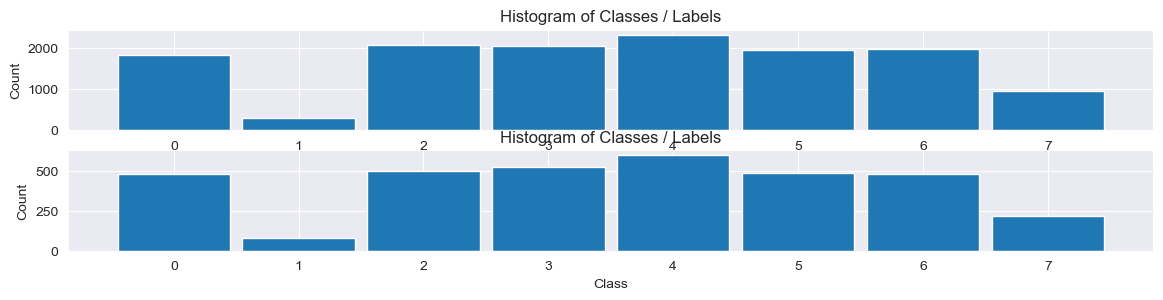

Train Data extrapulated with total 15988 samples collected with 40 features.


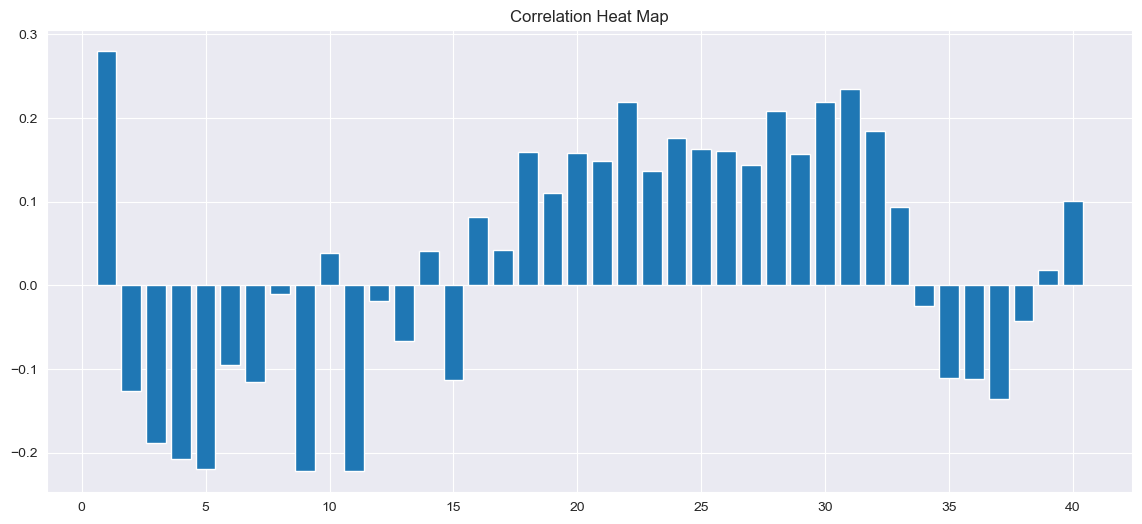

Prediction Train Accuracy: 99.94 %
Prediction Test Accuracy: 74.00 %


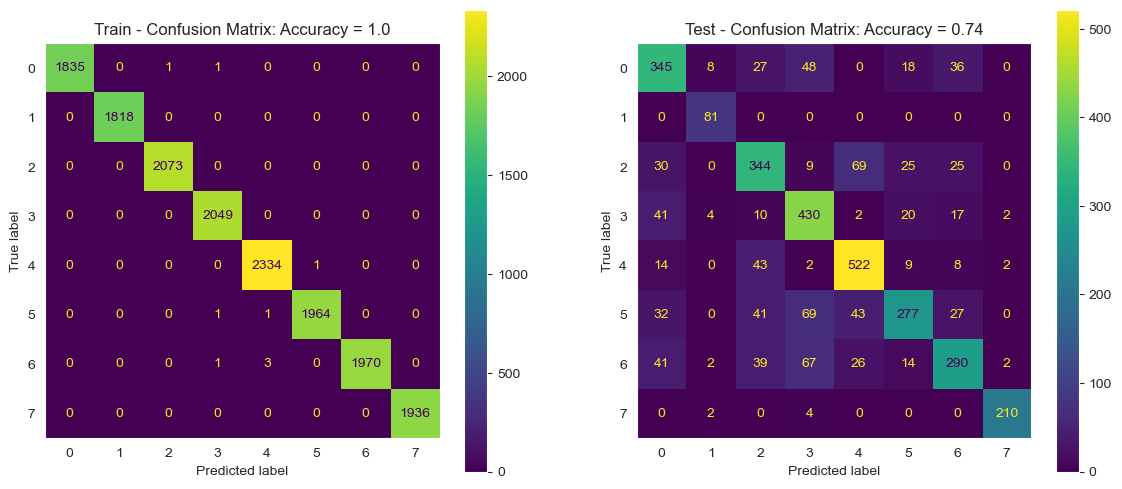

0.7400059224163459

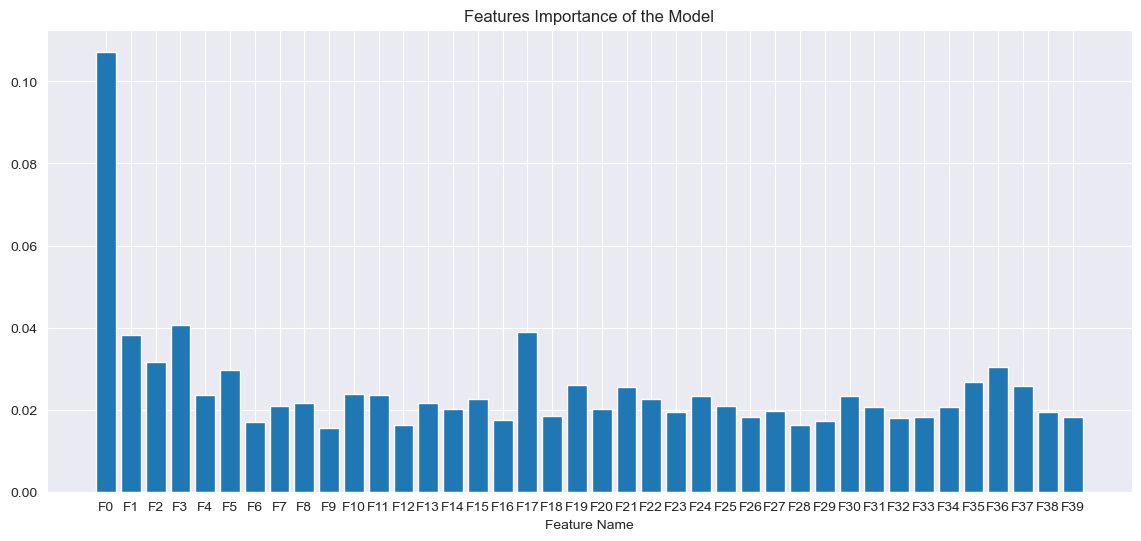

In [266]:
FeaturesGridSearch(FRAME_LEN,HOP_LEN,N,plot=True)

lN Grid Search:   0%|          | 0/4 [00:00<?, ?it/s]

Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 14 features.
Train Data extrapulated with total 15988 samples collected with 14 features.
Prediction Train Accuracy: 99.82 %
Prediction Test Accuracy: 74.06 %


Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 20 features.
Train Data extrapulated with total 15988 samples collected with 20 features.
Prediction Train Accuracy: 99.90 %
Prediction Test Accuracy: 73.50 %


Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 40 features.
Train Data extrapulated with total 15988 samples collected with 40 features.
Prediction Train Accuracy: 99.97 %
Prediction Test Accuracy: 73.62 %


Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 128 features.
Train Data extrapulated with total 15988 samples collected with 128 features.
Prediction Train Accuracy: 99.98 %
Prediction Test Accuracy: 72.34 %
Best score = 0.7405981640509328 of N = 14 .


Processing RAVDESS audio files:   0%|          | 0/50 [00:00<?, ?file/s]

Processing TESS audio files:   0%|          | 0/31 [00:00<?, ?file/s]

Processing CREMA-D audio files:   0%|          | 0/2 [00:00<?, ?file/s]

Processing SAVEE audio files:   0%|          | 0/11 [00:00<?, ?file/s]

Data with total 16882 samples collected with 14 features.


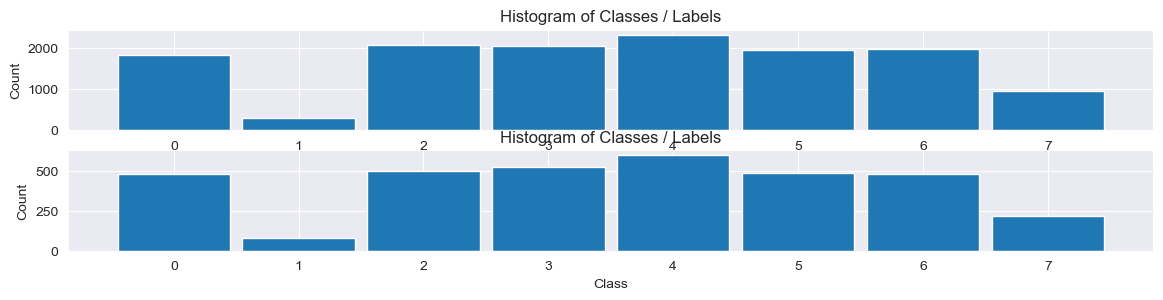

Train Data extrapulated with total 15988 samples collected with 14 features.


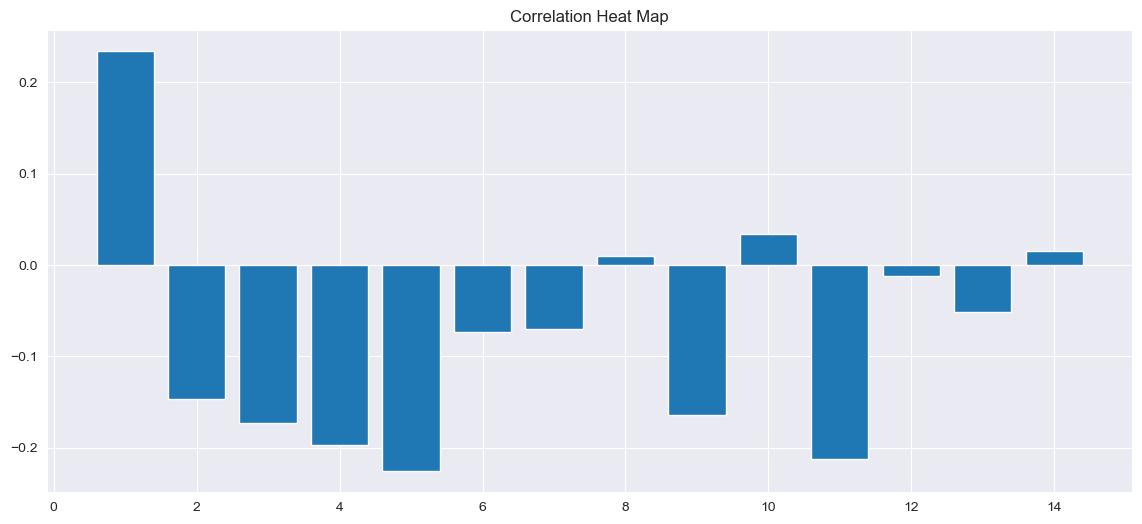

Prediction Train Accuracy: 99.82 %
Prediction Test Accuracy: 74.06 %


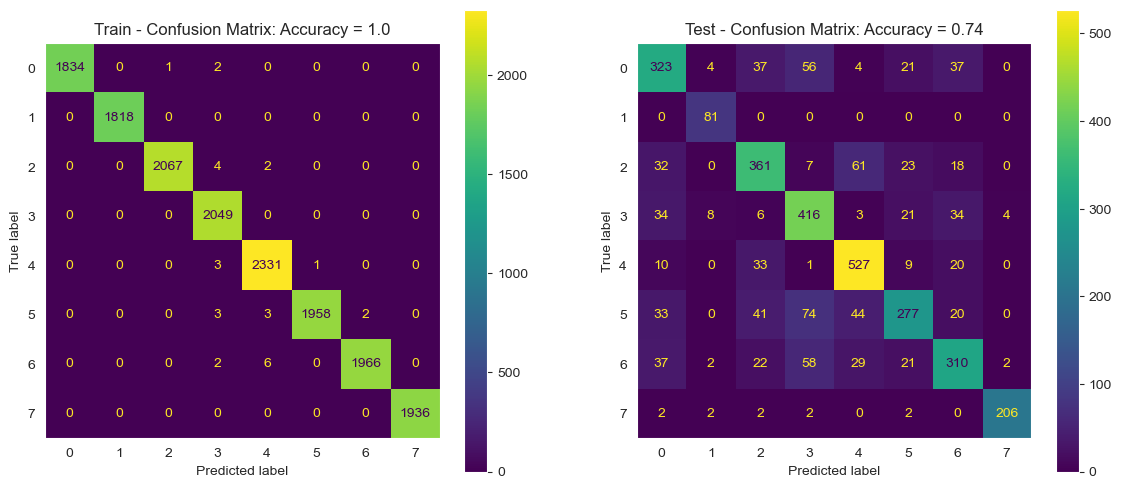

0.7405981640509328

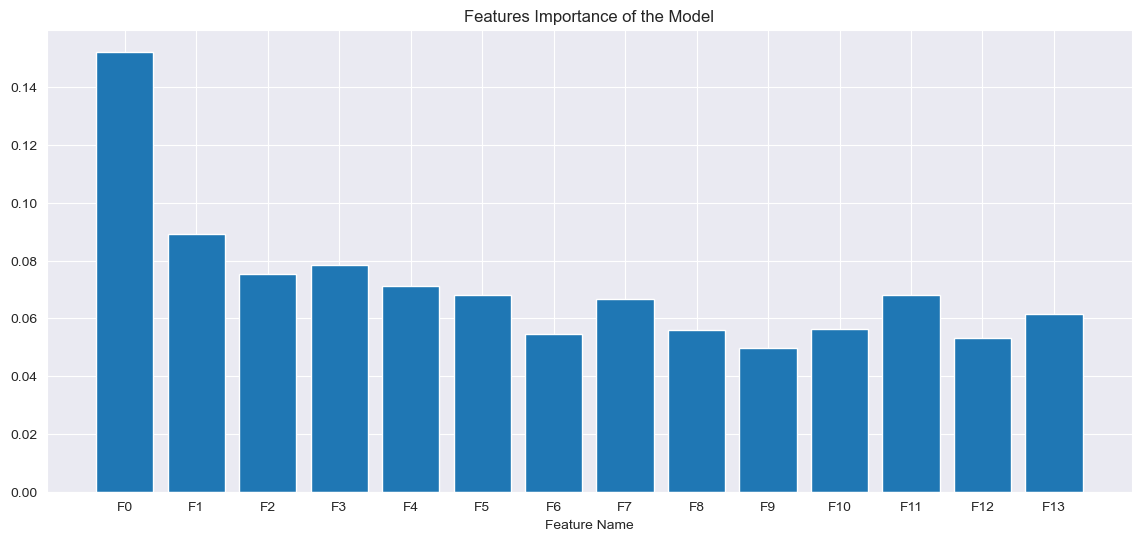

In [262]:
frame_len = 4096
hop_len = 2048
N = 14
F = 10
Z = 0.1
lN = [14,20,40,128]
bestScore = 0
bestN = 0
for N in tqdm(lN,desc="lN Grid Search"):
    score = FeaturesGridSearch(frame_len,hop_len,N,F,Z,plot=False)
    if(score > bestScore):
        bestScore = score
        bestN = N
print(f'Best score = {bestScore} of N = {bestN} .')
FeaturesGridSearch(frame_len,hop_len,bestN,F,Z,plot=True)